In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.add import UnaryAdd
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def add_test(rng="Sobol", row=128, col=10000, bitwidth=8):
    modes = ["bipolar", "unipolar"]

    scaled = [True, False]
    result_pe = []
    stype = torch.float
    buftype = torch.float
    randtype = torch.float

    for mode in modes:
        for scale in scaled:
            run_time = 0
            acc_dim = 0
            result_pe_cycle = []
            uadd = UnaryAdd(mode=mode, scaled=scale, acc_dim=acc_dim).to(device)

            if mode is "unipolar":
                iVec = torch.rand(row, col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
            elif mode is "bipolar":
                iVec = torch.rand(row, col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)
            
            oVec = torch.sum(iVec, acc_dim).to(device)

            iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode, randtype=randtype)().to(device)

            iVecRNG = RNG(bitwidth, 1, rng, randtype)().to(device)
            iVecBS = BSGen(iVecSource, iVecRNG, stype).to(device)

            iVecPE = ProgressiveError(iVec, scale=1, mode=mode).to(device)
            
            if scale is True:
                if acc_dim == 0:
                    oVecPE = ProgressiveError(oVec, scale=row, mode=mode).to(device)
                elif acc_dim ==1:
                    oVecPE = ProgressiveError(oVec, scale=col, mode=mode).to(device)
            else:
                oVecPE = ProgressiveError(oVec, scale=1, mode=mode).to(device)

            with torch.no_grad():
                idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
                for i in range(2**bitwidth):
                    iBS = iVecBS(idx + i)
                    iVecPE.Monitor(iBS)
                    
                    start_time = time.time()
                    oVecU = uadd(iBS)
                    run_time = time.time() - start_time + run_time
                    
                    oVecPE.Monitor(oVecU)
                    result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/col).item())
                print("--- %s seconds ---" % (run_time))
                print("input error: ", "min:", torch.min(iVecPE()[1]).item(), "max:", torch.max(iVecPE()[1]).item())
                print("output error: ", "min:", torch.min(oVecPE()[1]).item(), "max:", torch.max(oVecPE()[1]).item())
                result_pe = oVecPE()[1].cpu().numpy()
                print("error distribution=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                print("progressive accuracy=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.plot(result_pe_cycle)  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()

--- 0.13400721549987793 seconds ---
input error:  min: -0.0078125 max: 0.00390625
output error:  min: -0.008392333984375 max: 0.000732421875
error distribution=========>


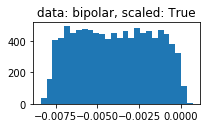

progressive accuracy=========>


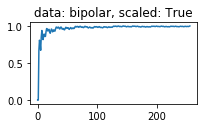

--- 0.1360006332397461 seconds ---
input error:  min: -0.0078125 max: 0.00390625
output error:  min: -0.9609375 max: 0.203125
error distribution=========>


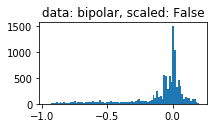

progressive accuracy=========>


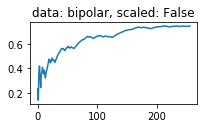

--- 0.11800575256347656 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.003936767578125 max: 0.0
error distribution=========>


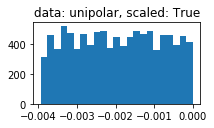

progressive accuracy=========>


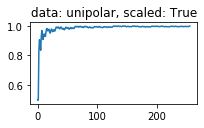

--- 0.1119997501373291 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: 0.0 max: 0.0
error distribution=========>


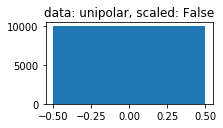

progressive accuracy=========>


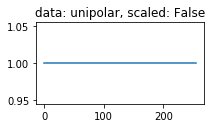

In [5]:
rng = "Sobol"
row = 128
col = 10000
bitwidth = 8
add_test(rng, row, col, bitwidth)

--- 0.132004976272583 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.008392333984375 max: 0.0006103515625
error distribution=========>


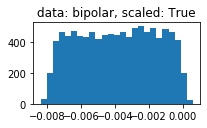

progressive accuracy=========>


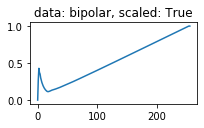

--- 0.1419997215270996 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.0078125 max: 1.96875
error distribution=========>


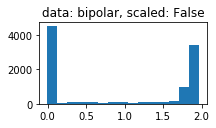

progressive accuracy=========>


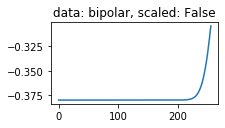

--- 0.1519911289215088 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.003875732421875 max: 0.0
error distribution=========>


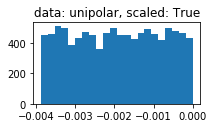

progressive accuracy=========>


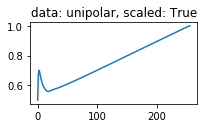

--- 0.10500001907348633 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0
error distribution=========>


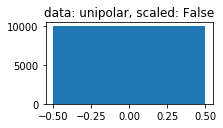

progressive accuracy=========>


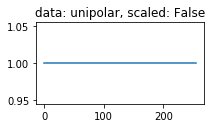

In [6]:
rng = "Race"
row = 128
col = 10000
add_test(rng, row, col)

--- 0.14099740982055664 seconds ---
input error:  min: -0.01171875 max: 0.00390625
output error:  min: -0.01593017578125 max: -0.006805419921875
error distribution=========>


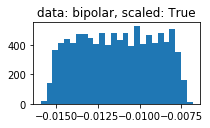

progressive accuracy=========>


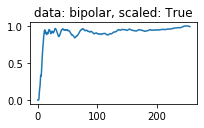

--- 0.14901018142700195 seconds ---
input error:  min: -0.01171875 max: 0.00390625
output error:  min: -0.578125 max: 1.234375
error distribution=========>


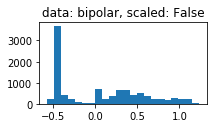

progressive accuracy=========>


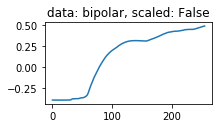

--- 0.11400008201599121 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.006378173828125 max: -0.001617431640625
error distribution=========>


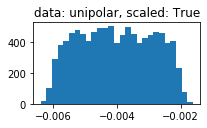

progressive accuracy=========>


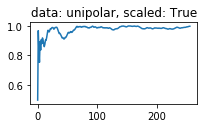

--- 0.11099791526794434 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: 0.0 max: 0.0
error distribution=========>


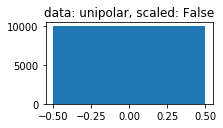

progressive accuracy=========>


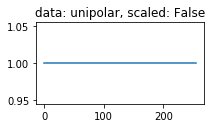

In [7]:
rng = "LFSR"
row = 128
col = 10000
add_test(rng, row, col)

--- 0.13698697090148926 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.008514404296875 max: 0.00054931640625
error distribution=========>


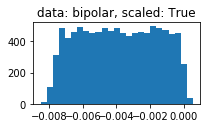

progressive accuracy=========>


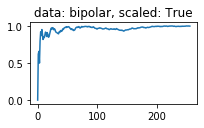

--- 0.13800334930419922 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.0546875 max: 0.6015625
error distribution=========>


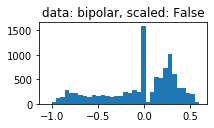

progressive accuracy=========>


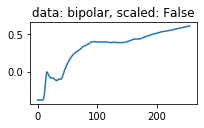

--- 0.10399985313415527 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.003875732421875 max: 0.0
error distribution=========>


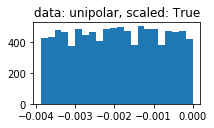

progressive accuracy=========>


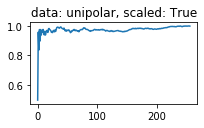

--- 0.11100220680236816 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0
error distribution=========>


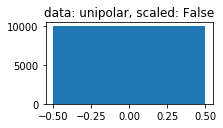

progressive accuracy=========>


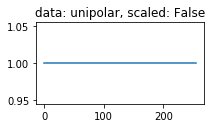

In [8]:
rng = "SYS"
row = 128
col = 10000
add_test(rng, row, col)